In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("sentiment_all.csv",encoding='utf-8')

subject_col="subject"
intensity_col="intensity"

print("各类短剧的样本量分布：")
print(df[subject_col].value_counts())
print("\n情感强度描述性统计：")
print(df.groupby(subject_col)[intensity_col].agg(["mean","std","count"]))


各类短剧的样本量分布：
古代言情    6375
现代言情    5476
奇幻      4367
家庭伦理    3377
逆袭      3009
萌宝      2755
Name: subject, dtype: int64

情感强度描述性统计：
             mean       std  count
subject                           
古代言情     2.941490  1.338127   6375
奇幻       3.095489  1.321202   4367
家庭伦理     3.072846  1.323780   3377
现代言情     3.327611  1.211080   5476
萌宝       3.366243  1.194799   2755
逆袭       3.008973  1.333234   3009


In [ ]:
df=df.dropna(subset=[subject_col,intensity_col])
df=df[(df[intensity_col]>=1) & (df[intensity_col]<=5)]
print(f"\n预处理后有效样本数：{len(df)}")


预处理后有效样本数：25359


In [ ]:

groups = [df[df[subject_col] == subject][intensity_col] for subject in df[subject_col].unique()]
levene_stat, levene_p = stats.levene(*groups)
print(f"\n方差齐性检验（Levene检验）：")
print(f"统计量：{levene_stat:.3f}，p值：{levene_p:.3f}")
if levene_p > 0.05:
    print("方差齐性满足（p>0.05），可进行ANOVA检验")
else:
    print("方差齐性不满足（p≤0.05），后续将用Welch ANOVA修正")




方差齐性检验（Levene检验）：
统计量：67.168，p值：0.000
方差齐性不满足（p≤0.05），后续将用Welch ANOVA修正


In [ ]:
if levene_p>0.05:
    model=ols(f"{intensity_col} ~ C({subject_col})",data=df).fit()
    anova_table=sm.stats.anova_lm(model,typ=2)
    f_stat,anova_p=anova_table["F"][0],anova_table["PR(>F)"][0]

else:
    welch_result=stats.f_oneway(*groups)
    f_state,anova_p=welch_result.statistic,welch_result.pvalue


In [ ]:

if anova_p < 0.05:
    print("ANOVA结果显著（p<0.05）：6类短剧的情感强度存在显著差异")
else:
    print("ANOVA结果不显著（p≥0.05）：6类短剧的情感强度无显著差异")

ANOVA结果显著（p<0.05）：6类短剧的情感强度存在显著差异


In [ ]:

if anova_p < 0.05:
    print("\n----------------------")
    print("事后检验（Tukey HSD）：明确差异来源")
    tukey = pairwise_tukeyhsd(
        endog=df[intensity_col],
        groups=df[subject_col],
        alpha=0.05 
    )
    print(tukey)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_df.to_csv("tukey_hsd_results.csv", index=False, encoding="utf-8")
    print("\n事后检验结果已保存至：tukey_hsd_results.csv")


----------------------
事后检验（Tukey HSD）：明确差异来源
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  古代言情     奇幻    0.154    0.0  0.0817  0.2263   True
  古代言情   家庭伦理   0.1314    0.0   0.053  0.2097   True
  古代言情   现代言情   0.3861    0.0  0.3183  0.4539   True
  古代言情     萌宝   0.4248    0.0  0.3409  0.5086   True
  古代言情     逆袭   0.0675 0.1694 -0.0139  0.1489  False
    奇幻   家庭伦理  -0.0226 0.9733  -0.107  0.0617  False
    奇幻   现代言情   0.2321    0.0  0.1575  0.3068   True
    奇幻     萌宝   0.2708    0.0  0.1812  0.3603   True
    奇幻     逆袭  -0.0865 0.0531 -0.1737  0.0007  False
  家庭伦理   现代言情   0.2548    0.0  0.1743  0.3353   True
  家庭伦理     萌宝   0.2934    0.0  0.1989  0.3879   True
  家庭伦理     逆袭  -0.0639 0.3577 -0.1561  0.0284  False
  现代言情     萌宝   0.0386 0.7956 -0.0473  0.1246  False
  现代言情     逆袭  -0.3186    0.0 -0.4021 -0.2351   True
    萌宝     逆袭  -0.3573    0.0 -0.4543 -0.2602   True

Text(0.5, 0.98, '')

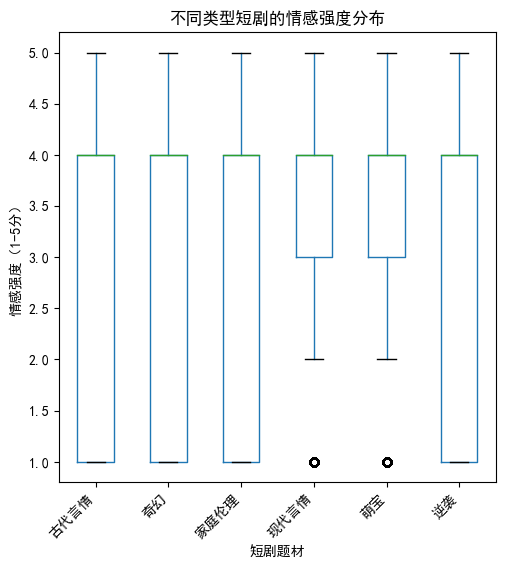

In [ ]:

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
df.boxplot(column=intensity_col, by=subject_col, grid=False, ax=plt.gca())
plt.title("不同类型短剧的情感强度分布", fontsize=12)
plt.xlabel("短剧题材", fontsize=10)
plt.ylabel("情感强度（1-5分）", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.suptitle("")  

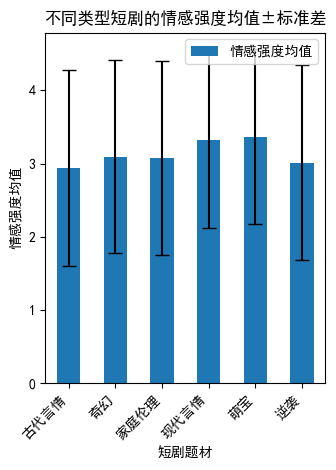

In [ ]:
plt.subplot(1, 2, 2)
mean_std = df.groupby(subject_col)[intensity_col].agg(["mean", "std"])
mean_std.plot(kind="bar", y="mean", yerr="std", capsize=5, ax=plt.gca())
plt.title("不同类型短剧的情感强度均值±标准差", fontsize=12)
plt.xlabel("短剧题材", fontsize=10)
plt.ylabel("情感强度均值", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.legend(["情感强度均值"])
plt.tight_layout()